In [103]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'..')
from src.server.db_api import connect
from src.storage.petastorm_storage_engine import PetastormStorageEngine
from src.readers.opencv_reader import OpenCVReader
from src.catalog.models.df_metadata import DataFrameMetadata
from src.storage.petastorm_storage_engine import PetastormStorageEngine, AbstractStorageEngine
from src.catalog.models.df_column import DataFrameColumn
from src.models.storage.batch import Batch
from src.catalog.column_type import ColumnType, NdArrayType
from typing import Iterator
import os
import ffmpeg
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Input #0, rawvideo, from 'pipe:':
  Duration: N/A, bitrate: 552960 kb/s
  Stream #0:0: Video: rawvideo (RGB[24] / 0x18424752), rgb24, 1280x720, 552960 kb/s, 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (rawvideo (native) -> h264 (libx264))
[libx264 @ 0x55ecc79ef9c0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX
[libx264 @ 0x55ecc79ef9c0] profile High 4:4:4 Predictive, level 3.1, 4:4:4, 8-bit
[libx264 @ 0x55ecc79ef9c0] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=4 threads=6 lookahead_threads=1 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_ref

## Petastorm

- Read a video using OpenCVReader
- Write video to petastorm storage using PetastormStorageEngine
- Read the video using PetastormStorageEngine

In [96]:
one_min_video = "/home/akshay/Downloads/pallof.mp4"
thirty_sec_video = "/home/akshay/Downloads/30secseinfeld.mkv"

In [97]:
%%time
# trying out time functionality
for i in range(100):
    a = 78 ** 90

CPU times: user 162 µs, sys: 4 µs, total: 166 µs
Wall time: 174 µs


In [11]:
table_info = DataFrameMetadata("dataset", 'dataset')
column_1 = DataFrameColumn("id", ColumnType.INTEGER, False)
column_2 = DataFrameColumn("data", ColumnType.NDARRAY, False, NdArrayType.UINT8, [1280, 720, 3])
table_info.schema = [column_1, column_2]
petastorm = PetastormStorageEngine()
petastorm.create(table_info)

21/11/29 02:06:46 WARN Utils: Your hostname, akshay-inspiron5423 resolves to a loopback address: 127.0.1.1; using 192.168.86.29 instead (on interface wlp7s0)
21/11/29 02:06:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/29 02:06:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
21/11/29 02:06:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/home/akshay/Desktop/GT/DSI/eva/evaenv/lib/python3.9/site-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  self._filesystem = pyarrow.localfs
/home/akshay/Desktop/GT/DSI/eva/evaenv/lib/python3.9/site-packages/

In [ ]:
%%time

opencv_reader = OpenCVReader(one_min_video, 30000000)
for batch in opencv_reader.read():
    petastorm.write(table_info, batch)

In [147]:
class FFmpegStorageEngine(AbstractStorageEngine):
    
    """
    Thread-unsafe storage engine that writes an entire sequence of frames out as a video, sequentially
    A video is a _baked_ format
    """
    
    STORAGE_PATH = "ffmpeg_data"
    STORAGE_FORMAT = "mp4"
    
    def __init__(self):
        self.write_location = None
        self.writer_process = None
    
    def _file_url(self, table: DataFrameMetadata):
        return "/".join([self.STORAGE_PATH, table.file_url])
    
    def create(self, table: DataFrameMetadata):
            if not os.path.exists(self.STORAGE_PATH):
                os.makedirs(self.STORAGE_PATH)
            # assert: directory present for storing files
            file_location = self._file_url(table)
            
            # create empty file in filesystem
            open(file_location, "w").close()
            
    def open_write(self, table: DataFrameMetadata):
        assert self.write_location == None
        file_location = self._file_url(table)
        width, height = table.resolution
        self.writer_process = (
            ffmpeg
            .input('pipe:', format='rawvideo', pix_fmt='bgr24', s='{}x{}'.format(width, height))
            .output(file_location + "." + self.STORAGE_FORMAT, format=self.STORAGE_FORMAT)
            .overwrite_output()
            .run_async(pipe_stdin=True)
        )
    
    def write(self, table: DataFrameMetadata, rows: Batch):
        height, width = table.resolution
        frames = rows.frames['data'].values
        
        for frame in frames:
        
            self.writer_process.stdin.write(
                frame
                .astype(np.uint8)
                .tobytes()
            )
                
            
    def read(self, table, pos, select=None) -> Iterator[Batch]:
        """
        table: DataframeMetadata
        pos: frame number 
        select-expr: ffmpeg select expression
        """ 
        video_file = self._file_url(table) + "." + self.STORAGE_FORMAT
        height, width = table.resolution
       
        out, _ = (
            ffmpeg
            .input(video_file)
            .filter('select', 'gte(n,{})'.format(pos))
            .output('pipe:', vframes=1, format='rawvideo', pix_fmt='rgb24')
            .run(capture_stdout=True)
        )
    
        image = (
            np
            .frombuffer(out, np.uint8)
            .reshape([width, height, 3])
        )
    
        return image
        
    
    def _open(self, table):
        pass
    
    def _close(self, table):
        pass
    
    def close_write(self, table):
        # use this to stop the async ffmpeg process
        self.writer_process.stdin.close()
        self.writer_process.wait()
        self.writer_process = None
    
    def _read_init(self, table):
        # use this to start the async ffmpeg read process
        pass
        

In [144]:
opencv_reader = OpenCVReader(one_min_video, 30000000)
ffengine = FFmpegStorageEngine()
seinfeldtable = DataFrameMetadata("oneminseinfeld", "seinfeldvideo")
seinfeldtable.resolution = (1280, 720)
ffengine.create(seinfeldtable)
ffengine.open_write(seinfeldtable)
for batch in opencv_reader.read():
    ffengine.write(seinfeldtable, batch)
ffengine.close_write(seinfeldtable)



ffmpeg version n4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11.1.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxvid -

ffmpeg_data/seinfeldvideo.mp4


ffmpeg version n4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11.1.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxcb --enable-libxml2 --enable-libxvid -

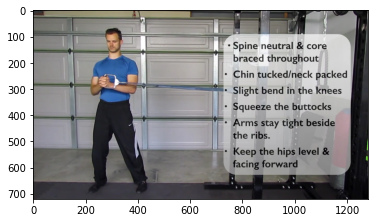

In [146]:
f2fengine = FFmpegStorageEngine()
image = f2fengine.read(seinfeldtable, 600)
plt.imshow(image)